In [1]:
import pickle
import numpy as np
import pandas as pd

# import efficientnet.keras as efn

# from __future__ import division
# from __future__ import print_function

from tensorflow.keras.layers import Lambda, Dense, TimeDistributed, Input, Flatten, MaxPool2D, Reshape, UpSampling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, concatenate, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# from vgg16 import VGG16
from tensorflow.keras.applications import VGG16, VGG19, NASNetLarge, InceptionV3, EfficientNetB7
from tensorflow.keras.applications.vgg19 import preprocess_input

import scipy.io
from scipy.spatial.distance import braycurtis, cosine, canberra, chebyshev, cityblock, correlation, euclidean, mahalanobis, minkowski, seuclidean, sqeuclidean, wminkowski 
import os
import matplotlib.pyplot as plt
import cv2
from time import time
from random import randint

from create_model import create_model

In [2]:
print(randint(30, 70) / 100)

0.44


In [3]:
def load_image(path):
    img = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (224, 224))

    return img

In [7]:
x_path = 'Base_Money_Mask_600/Photo/Cash_300/'
y_path = 'Base_Money_Mask_600/Mask/Cash_300/'

In [8]:
imgs_name = sorted(os.listdir(x_path), key=lambda x: (len(x), x))

In [9]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

cast = {'dice_coef':dice_coef}

In [10]:
# model = create_model()
model = load_model('segmentation_banknote.h5', custom_objects=cast)

In [31]:
# Возвращаем площадь пересечения деленную на площадь объединения двух областей

model.compile(optimizer=Adam(lr=1e-6),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])

In [11]:
def mask_img_zoom(img, mask):
    img[mask==0] = 0
    s = int(img.shape[0] * (randint(50, 100)/100))
    img = cv2.resize(np.pad(cv2.resize(img, (s, s)), (((img.shape[0] - s) // 2,), ((img.shape[0] - s) // 2,), (0,))), 
                     (224, 224))
    mask = cv2.resize(np.pad(cv2.resize(np.uint8(mask), (s, s)), (((mask.shape[0] - s) // 2,), ((mask.shape[0] - s) // 2,), (0,))), 
                     (224, 224))
    return img, mask

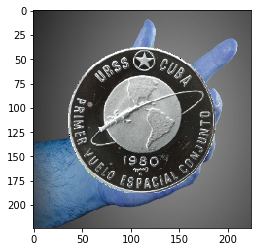

In [46]:
# img = load_image(x_path + '62078a.jpg')
# mask = load_image(y_path + 'm62078a.png')
img = load_image(x_path + '3614a.jpg')
mask = load_image(y_path + 'm3614a.png')
mask_new = np.asarray(list(map(lambda q: np.asarray(list(map(lambda x: (0 if x[0] == 255 and x[1] == 255 and x[2] == 255 else 1), q))), mask)))
mask_new = np.stack([mask_new, mask_new, mask_new], axis=2)
zoom_img, zoom_mask = mask_img_zoom(img, mask_new)
back = load_image('фоны/' + '95.jpg')
back[zoom_mask==1] = 0
image = zoom_img + back
plt.imshow(image)

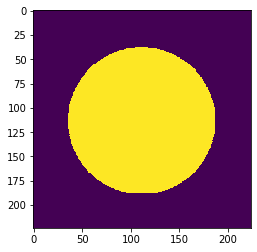

In [47]:
plt.imshow(zoom_mask[:,:,0])

In [12]:
sorted(os.listdir('фоны'), key=(lambda x: (len(x), str(x))))[-2:]

['89.jpg', '90.jpg']

In [48]:
for _ in range(1):
    for filename in imgs_name:
        x = []
        y = []
        x.append(load_image(x_path + filename))
        mask = load_image(y_path + 'm' + filename[:-4] + '.png')
        mask_new = np.asarray(list(map(lambda q: np.asarray(list(map(lambda x: (0 if x[0] == 255 and x[1] == 255 and x[2] == 255 else 1), q))), mask)))
        y.append(mask_new.reshape(224, 224, 1))
        mask_new = np.stack([mask_new, mask_new, mask_new], axis=2)
        img = preprocess_input(load_image(x_path + filename))
        for backname in os.listdir('фоны'): 
            zoom_img, zoom_mask = mask_img_zoom(img, mask_new)
            back = load_image('фоны/' + backname)
            back[zoom_mask==1] = 0
            image = zoom_img + back
            x.append(image)
            y.append(zoom_mask[:,:,0].reshape(224, 224, 1))
        x = np.asarray(x)
        y = np.asarray(y)
    #     y = np.asarray(list(map(lambda w: np.asarray(list(map(lambda q: np.asarray(list(map(lambda x: (0 if x[0] == 255 and x[1] == 255 and x[2] == 255 else 1), q))), w))), y)))
        model.fit(x, y, batch_size=10, epochs=1)
#     y.append(np.uint8(cv2.cvtColor(load_image(y_path + 'm' + filename[:-4] + '.png'), cv2.COLOR_BGR2GRAY)))
# model.save('segmentation')

10/10 [==============================] - 6s 599ms/step - loss: 0.0091 - dice_coef: 0.9948


10/10 [==============================] - 6s 599ms/step - loss: 0.0083 - dice_coef: 0.9908


In [13]:
def segmentation(image):
    predict = (model.predict(image[None])[0]).round().reshape(224, 224)
    mask = np.stack([predict, predict, predict], axis=2)
    img = image.copy()
    img[mask==0] = 0
    idx1 = np.argwhere(np.all(mask[..., :] == 0, axis=0))
    idx2 = np.argwhere(np.all(mask[..., :] == 0, axis=1))
    image = np.delete(image, idx1, axis=1)
    image = np.delete(image, idx2, axis=0)
    image = cv2.resize(image, (224, 224))
    img = np.delete(img, idx1, axis=1)
    img = np.delete(img, idx2, axis=0)
    img = cv2.resize(img, (224, 224))
#     contours, hierarchy = cv2.findContours(np.uint8(mask[:,:,0]), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     contours = cv2.findContours(np.uint8(mask[:,:,0]), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     contours = contours[0] if len(contours) == 2 else contours[1]
#     print(contours)
    return img

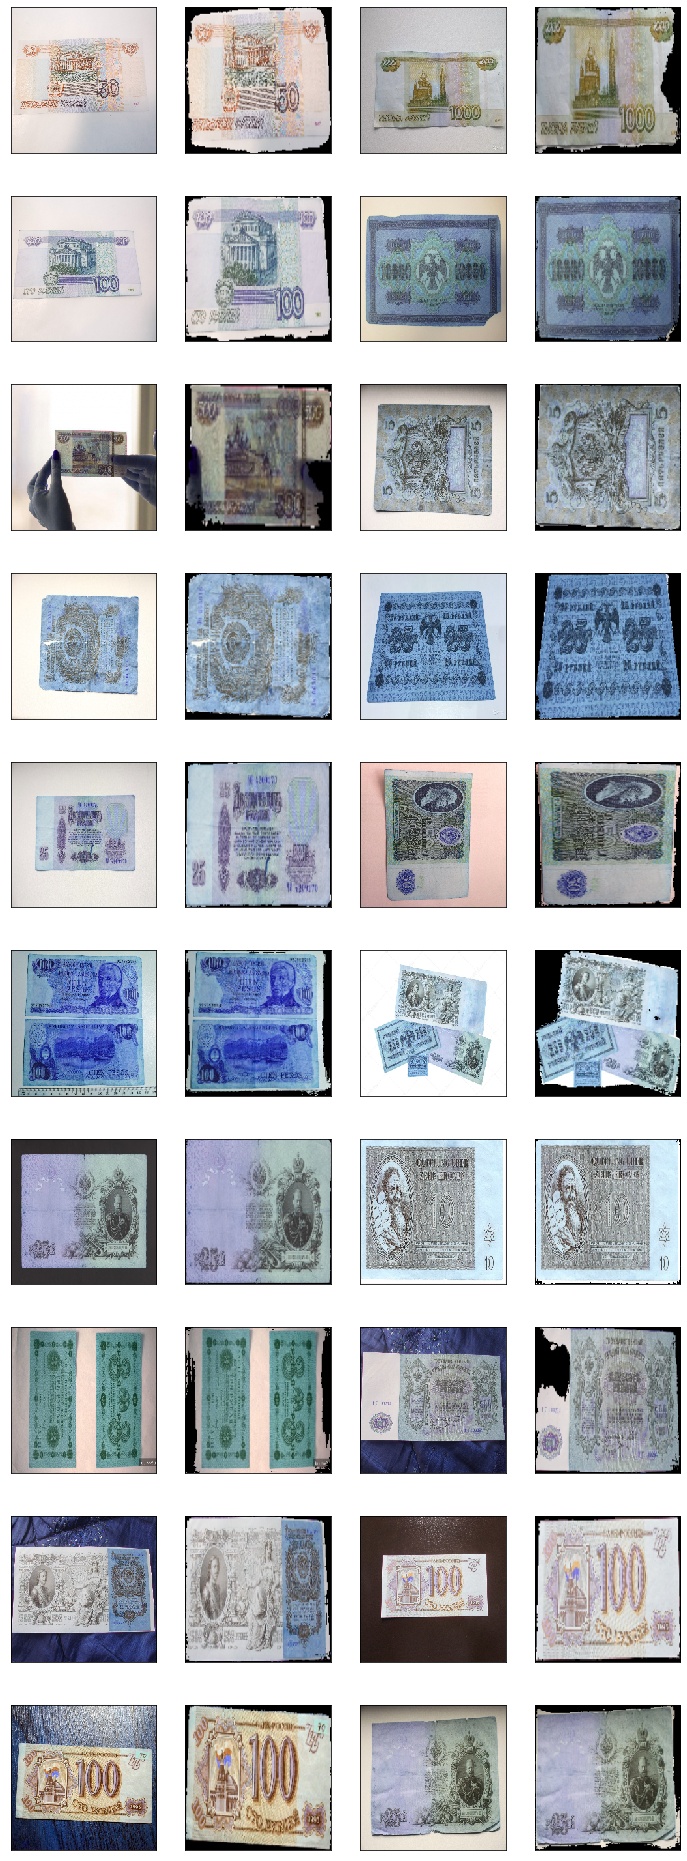

In [14]:
plt.figure(figsize=(12, 48))
q = 1
for i in range(1, 21):
    filename = f'segmentation_cash_test/{i}.jpg'
    
    image = load_image(filename)
    img = segmentation(image)
    plt.subplot(14, 4, q)
    plt.imshow(load_image(filename))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(14, 4, q + 1)
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    q += 2
plt.show()

In [51]:
model.save('segmentation_coin_v3.h5')

In [45]:
for i in contours:
    print(len(i))

4
6
6
4
4
2
1
6
6
289


In [47]:
contours[-1].shape

(289, 1, 2)